In [2]:
import math
import numpy as np
from datetime import datetime, timedelta, date
import time
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
def speedstats(dsspeed, percent=False):
    bins=list(range(0,int(dsspeed["speed"].max())+2))
    sg = dsspeed.groupby_bins("speed",bins)
    speedcounts = sg.count(...)["speed"]
    speedlabelsdict={}
    for k in sg.groups:
        speedlabelsdict[k.left]=k
    speedlabels=[]    
    for k in sorted(speedlabelsdict):
        speedlabels.append("%s"%speedlabelsdict[k])
    if percent:
        alldscount = dsspeed["speed"].count().item(0)
        speedcounts = speedcounts/alldscount
    return speedlabels, speedcounts

In [21]:
def directionstats(dsdir, percent=False):
    dirlabels = ["N","NE", "E", "SE", "S", "SW", "W", "NW"]
    dirgroup = dsdir.groupby("wind_dir_cat")
    dircounts = dirgroup.count(...)["wind_dir"]
    if percent:
        alldscount = dsdir["speed"].count().item(0)
        dircounts = dircounts/alldscount
    return dirlabels, dircounts

In [6]:
ds = xr.load_dataset("/home/sg/Downloads/p1_17_21.nc")

In [7]:
ds['speed'] = np.sqrt(ds.u10**2+ds.v10**2)

In [10]:
ds['wind_dir'] = 180 + (180 / math.pi) * np.arctan2(ds.u10, ds.v10)

In [15]:
def wind_direction_disc(azim):
    wind_dir = np.ma.copy(azim)
    # wind_dir
    # wind_dir.shape, azim[1].size
    # wind_dir
    directiondict = {1: (337.5, 22.5), # N
                     2: (22.5, 67.5), # NE
                     3: (67.5, 112.5), # E
                     4: (112.5, 157.5), # SE
                     5: (157.5, 202.5), # S
                     6: (202.5, 247.5), # SW
                     7: (247.5, 292.5), # W
                     8: (292.5, 337.5)}  # NW
    for i in directiondict:
        if directiondict[i][0] > directiondict[i][1]:
            wind_dir[(~wind_dir.mask) & ((wind_dir > directiondict[i][0]) | (wind_dir <= directiondict[i][1]))] = i
        else:
            wind_dir[(~wind_dir.mask) & (wind_dir > directiondict[i][0]) & (wind_dir <= directiondict[i][1])] = i
    return wind_dir

In [16]:
ds['wind_dir_cat'] = xr.apply_ufunc(wind_direction_disc, ds['wind_dir'])

/home/sg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/sg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/sg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/sg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [18]:
dscell = ds.sel(latitude=slice(37.95,37.85), longitude=slice(23.85, 23.95))
dscell

<xarray.Dataset>
Dimensions:       (expver: 2, latitude: 1, longitude: 1, time: 23983)
Coordinates:
  * longitude     (longitude) float32 23.92
  * latitude      (latitude) float32 37.92
  * expver        (expver) int32 1 5
  * time          (time) datetime64[ns] 2017-04-01 ... 2021-08-22T06:00:00
Data variables:
    u10           (time, expver, latitude, longitude) float32 0.94747806 ... nan
    v10           (time, expver, latitude, longitude) float32 -4.8378425 ... nan
    fg10          (time, expver, latitude, longitude) float32 12.375712 ... 11.684931
    i10fg         (time, expver, latitude, longitude) float32 12.060875 ... 12.193236
    speed         (time, expver, latitude, longitude) float32 4.92975 ... nan
    wind_dir      (time, expver, latitude, longitude) float32 348.91904 ... nan
    wind_dir_cat  (time, expver, latitude, longitude) float32 1.0 nan ... nan
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-26 12:42:54 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<BarContainer object of 12 artists>

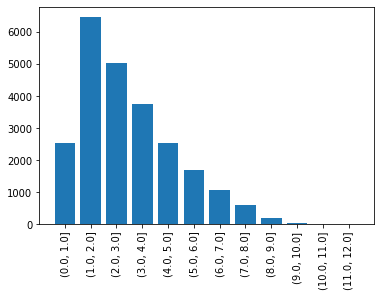

In [19]:
lab, speeds = speedstats(dscell)
plt.xticks(rotation=90)
plt.bar(lab,speeds)

<BarContainer object of 8 artists>

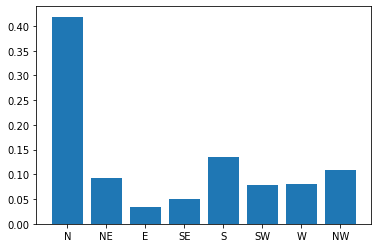

In [22]:
directions,dircounts = directionstats(dscell, percent=True)
plt.bar(directions,dircounts)

In [359]:
start="2010-01-01"
end="2020-12-31"
dstimerange=dscell.sel(time=slice(start, end))

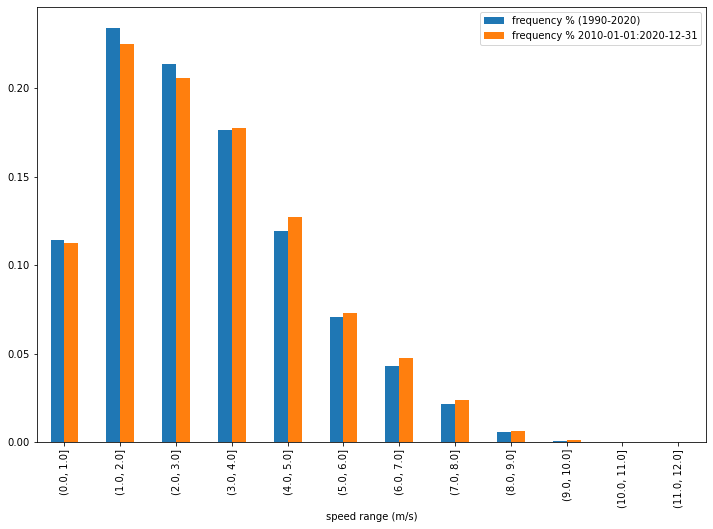

In [371]:
lab1, speeds1 = speedstats(dscell, percent=True)
lab2, speeds2 = speedstats(dstimerange, percent=True)
speeds2 = np.append(speeds2, np.zeros(len(speeds1)-len(speeds2), dtype=np.int8))
dfplt=pd.DataFrame({"speed range (m/s)":lab1, "frequency % (1990-2020)":speeds1, "frequency %% %s:%s"%(start,end):speeds2})
dfplt.plot.bar(x='speed range (m/s)',  figsize=(12,8), logy=False)

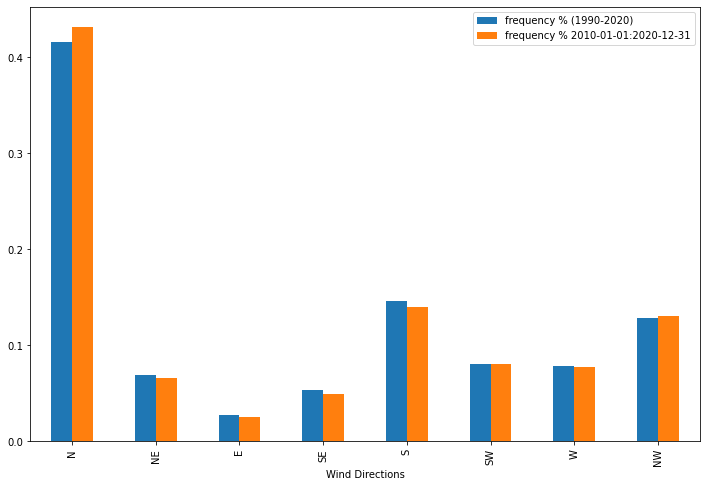

In [364]:
lab1, dirs1 = directionstats(dscell, percent=True)
lab2, dirs2 = directionstats(dstimerange, percent=True)
dfplt=pd.DataFrame({"Wind Directions":lab1, "frequency % (1990-2020)":dirs1, "frequency %% %s:%s"%(start,end):dirs2, })
dfplt.plot.bar(x="Wind Directions", figsize=(12,8))

In [380]:
dscell[dscell.direction==1]

TypeError: unhashable type: 'numpy.ndarray'